In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
sys.path.append('..')
import dnnlib
from torch_utils import distributed as dist
from torch_utils import training_stats
from torch_utils import misc
import glob

from generate import *
from training.fractional_gaussian import rand_fractional_gaussian, rand_fractional_gaussian_like

device = torch.device("cuda:0")

In [136]:
def tensor_to_image(images, horv='v', normalize = False):
    if horv == 'h':
        if normalize:
            images = ((images-torch.min(images))/(torch.max(images)-torch.min(images))).to(torch.uint8).permute(2, 0, 3, 1).cpu().numpy()
        else:
            images = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(2, 0, 3, 1).cpu().numpy()
        h,b,w,c = images.shape
        images = images.reshape(h,w*b,c)
        if images.shape[2]==1:
            return PIL.Image.fromarray(images[:,:,0], 'L')
        elif images.shape[2]==3:
            return PIL.Image.fromarray(images, 'RGB')
    else:
        if normalize:
            images = ((images-torch.min(images))/(torch.max(images)-torch.min(images))).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
        else:
            images = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
        h,b,w,c = images.shape
        images = images.reshape(h*b,w,c)
        if images.shape[2]==1:
            return PIL.Image.fromarray(images[:,:,0], 'L')
        elif images.shape[2]==3:
            return PIL.Image.fromarray(images, 'RGB')
    
def image_to_tensor(pil_img):
    tensor_img = torch.tensor(np.array(pil_img))
    if len(tensor_img.shape) == 2:
        tensor_img = ((tensor_img.to(torch.float32) - 128) / 127.5).to(device)
    else:
        assert len(tensor_img.shape) == 3
        tensor_img = ((tensor_img.to(torch.float32) - 128) / 127.5).permute(2, 0, 1).to(device)
        if tensor_img.shape[0] == 4: tensor_img = tensor_img[:3]
    return tensor_img.unsqueeze(0)

def images_to_tensor(pil_imgs):
    tensors = [image_to_tensor(img) for img in pil_imgs]
    return torch.cat(tensors, dim=0)
    
def image_array(images, columns=4, scale=3):
    height = int(images[0].size[1]/images[0].size[0])
    fig, axs = plt.subplots(int(len(images)/(columns+.01))+1, columns, figsize=(columns*scale,height*scale), frameon=False)
    plt.subplots_adjust(wspace=0, hspace=0)
    if len(images)<=columns:
        for i,img in enumerate(images):
            axs[i].imshow(img)
            axs[i].set_axis_off()
    else:
        for i,img in enumerate(images):
            axs[i//columns,i%columns].imshow(img)
            axs[i//columns,i%columns].set_axis_off()

def select_random_images(directory, number=1, seed = 0):
    random.seed(seed)
    imgs = random.sample(glob.glob(directory+'/*.png'),number)
    return [PIL.Image.open(img) for img in imgs]

In [2]:
net = torch.load('training-state-022300.pt')['net'].cuda()

In [144]:
latents = rand_fractional_gaussian((4,3,256,256), ).cuda()


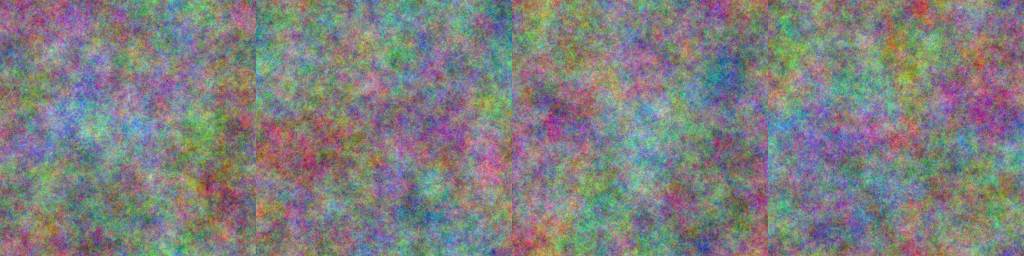

In [154]:
tensor_to_image(latents/5, horv='h')

In [190]:
with torch.no_grad():
    result = denoising_sampler(net=net, latents=latents, class_labels=None, randn_like=rand_fractional_gaussian_like,
        num_steps=100, sigma_min=0.002, sigma_max=80, rho=7,
        S_churn=0, S_min=0, S_max=float('inf'), S_noise=0,
    )

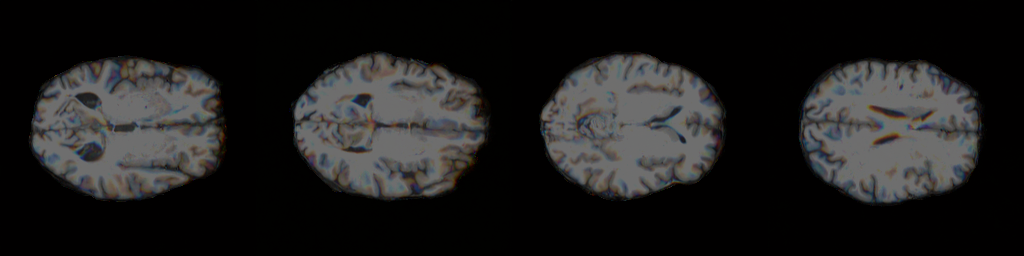

In [191]:
tensor_to_image(result, horv='h')

In [192]:
with torch.no_grad():
    latent_result = noising_sampler(net=net, latents=result, class_labels=None, randn_like=rand_fractional_gaussian_like,
        num_steps=100, sigma_min=0.002, sigma_max=80, rho=7,
        S_churn=0, S_min=0, S_max=float('inf'), S_noise=0,
    )

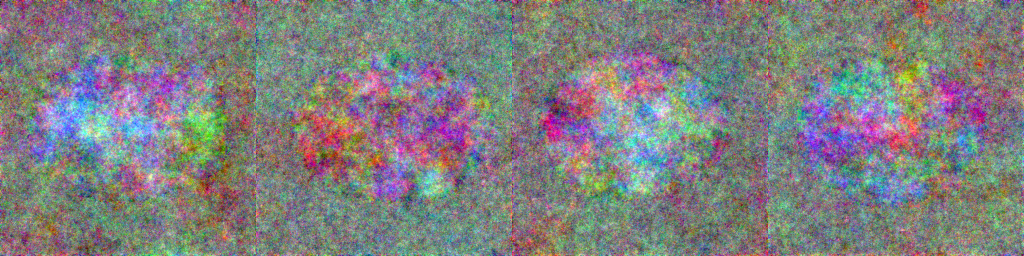

In [193]:
tensor_to_image(latent_result/260, horv='h')

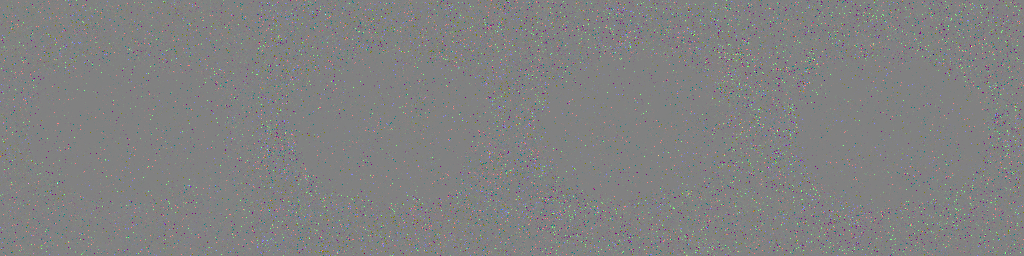

In [194]:
tensor_to_image(latents/latent_result, horv='h')

# Adding in an artifact

In [205]:
# mask = torch.zeros_like(result)
# # mask[:, :, 150:200, 150:200] = 1
# mask[:, :, 70:120, 90:110] = 1
# mask = mask * torch.randn_like(result)
# artifact_result = result - result * mask * 0.5
import scipy.ndimage

artifact_result = torch.tensor(scipy.ndimage.zoom(np.array(result.cpu()), (1,1,0.8,1.2)))

In [206]:
artifact_result.shape

torch.Size([4, 3, 205, 307])

In [207]:
(artifact_result.shape[3]-result.shape[3])//2

25

In [208]:
new_artifact_result = -1 * torch.ones_like(result)
new_artifact_result[:, :, -(artifact_result.shape[2]-result.shape[2])//2:(artifact_result.shape[2]-result.shape[2])//2, :]= artifact_result[:,:,:,(artifact_result.shape[3]-result.shape[3])//2:-(artifact_result.shape[3]-result.shape[3])//2]
artifact_result = new_artifact_result.cuda()

In [209]:
artifact_result.shape

torch.Size([4, 3, 256, 256])

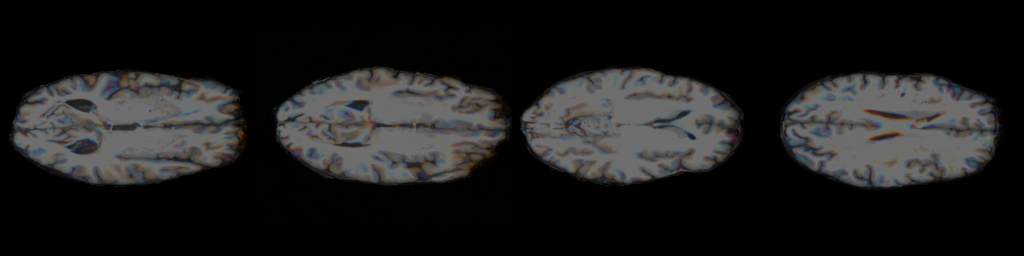

In [210]:
tensor_to_image(artifact_result, horv='h')

In [211]:
with torch.no_grad():
    latent_result = noising_sampler(net=net, latents=artifact_result, class_labels=None, randn_like=rand_fractional_gaussian_like,
        num_steps=100, sigma_min=0.002, sigma_max=80, rho=7,
        S_churn=0, S_min=0, S_max=float('inf'), S_noise=0,
    )

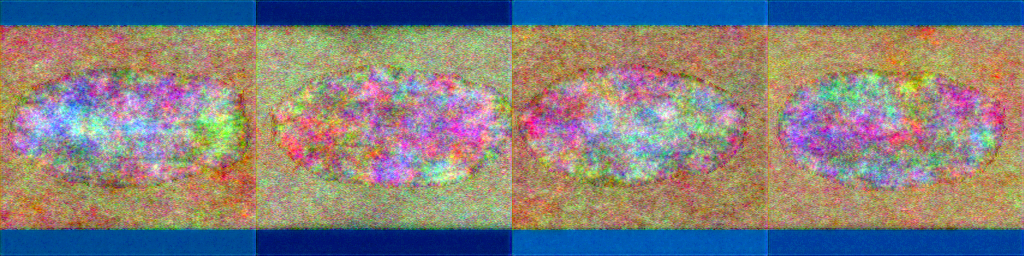

In [212]:
tensor_to_image(latent_result/260, horv='h')

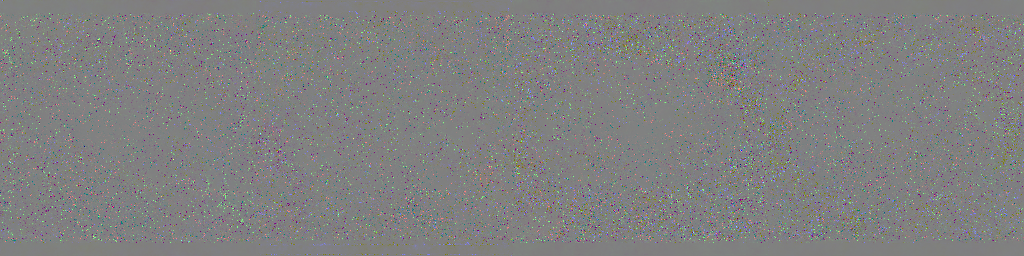

In [203]:
tensor_to_image(latents/latent_result, horv='h')

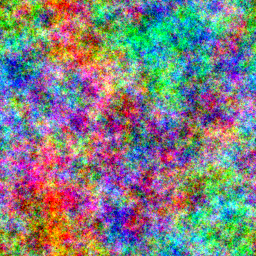

In [139]:
tensor_to_image(rand_fractional_gaussian((1,3,256,256), )/2)

In [215]:
images = [Image.open(file) for file in glob.glob('BraTS/*')]

In [218]:
bt_images = images_to_tensor(images, )

NameError: name 'device' is not defined

In [ ]:
bt_images